# Transit-Only Fit Example: WASP-97 b

## Importing ExoMUSE and required libraries

In [1]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [2]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

import lightkurve as lk

In [3]:
#We then import the ExoMUSE codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [4]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [5]:
#We import the datasets.
#Since this is an Transit-Only Fit we import:
    #Transit Data

#Instead of importing the transit data, we can also download it using lightkurve library.
#For this we first define the name of our target.
target_name = "WASP-97"

#We then look for the light curve data of this target using lightkurve.
#For the exposure time, we pick 1800 seconds (30 minutes).
#Note that the search may take a while depending on the target and available data.
data_search = lk.search_lightcurve(target_name, exptime = 1800)

data_search

SearchResult containing 9 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 02 2018         TESS-SPOC    1800   230982885      0.0
  1 TESS Sector 02 2018               QLP    1800   230982885      0.0
  2   TESS Sector  2018          DIAMANTE    1800   230982885      0.0
  3 TESS Sector 02 2018 GSFC-ELEANOR-LITE    1800   230982885      0.0
  4 TESS Sector 02 2018               T16    1800   230982885      0.0
  5 TESS Sector 02 2018             TASOC    1800   230982885      0.0
  6 TESS Sector 02 2018             TASOC    1800   230982885      0.0
  7 TESS Sector 02 2018              TGLC    1800   230982885      0.0
  8 TESS Sector 29 2020             CDIPS    1800   230982885      0.0

In [6]:
#We select one of the datasets from our data search results.
selected_lc_data = data_search[1]

selected_lc_data

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 02 2018    QLP    1800   230982885      0.0

In [7]:
#We then download the selected light curve data.
#Note that the download may take a while depending on the size of the dataset.
lc_data = selected_lc_data.download()

lc_data

<TessLightCurve length=1228 LABEL="TIC 230982885" SECTOR=2 AUTHOR=QLP FLUX_ORIGIN=sap_flux>
       time               flux        ... kspsap_flux_sml kspsap_flux_lag
                                      ...                                
       Time             float32       ...     float32         float32    
------------------ ------------------ ... --------------- ---------------
1354.1389305486052 1.0002059936523438 ...        1.000572       1.0006598
1354.1597641932947 1.0000331401824951 ...       1.0003514       1.0004586
1354.1805978376394 0.9992520809173584 ...       0.9997207      0.99957055
 1354.201431481613 0.9994047284126282 ...      0.99980503       0.9997462
1354.2222651252193 0.9999504685401917 ...       1.0003215       1.0002767
1354.2430987684631 0.9991915822029114 ...       0.9996882       0.9993695
 1354.263932411318 0.9993406534194946 ...      0.99957234      0.99971193
1354.2847660537996 0.9998270869255066 ...       1.0001265       1.0001581
1354.3055996958824 0.9998926520347595 ...       1.0001045       1.0002363
               ...                ... ...             ...             ...
1381.3265013437522 1.0009177923202515 ...       1.0003892       1.0004007
1381.3473344805946 1.0008573532104492 ...       1.0003128       1.0003989
1381.3681676173273 1.0002949237823486 ...      0.99982524       0.9997743
 1381.389000753949  1.000227689743042 ...       0.9998164      0.99970055
 1381.409833890457 1.0004147291183472 ...      0.99990165         0.99987
1381.4306670268802 1.0005067586898804 ...       1.0000263        1.000101
 1381.451500163216 1.0007953643798828 ...       1.0002363       1.0003374
1381.4723332994727 1.0001238584518433 ...       0.9997664       0.9994977
1381.4931664356577 1.0004807710647583 ...      0.99993324       1.0000378

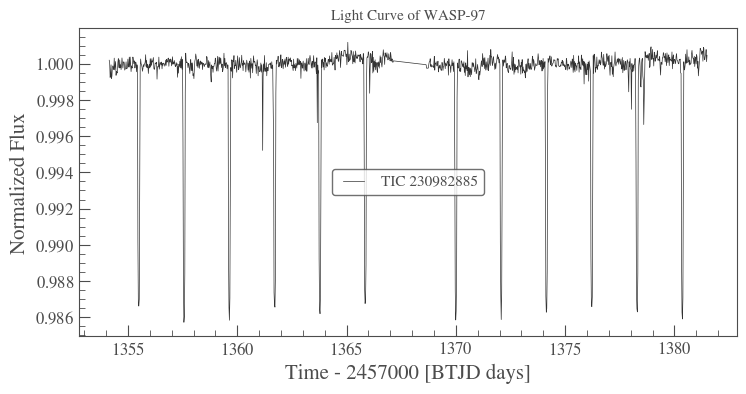

In [8]:
#We then remove possible "Not a Number (NaN)" values from the light curve data.
#We also normalize the fluxes to 1 on the same code line.
lc = lc_data[lc_data.flux.value > 0].remove_nans().normalize()

#We can then quickly plot the light curve data.
lc.plot()
plt.title(f"Light Curve of {target_name}")
plt.show()

In [10]:
#We then define raw datas of time, flux, and flux error as arrays.
t = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value

In [11]:
#We can also mask out the data depending on the quality value.
quality = lc.quality.value
mask = quality == 0

#We then setup a dataframe that contains the time, flux, and flux error values.
df = pd.DataFrame()
df["time"] = t[mask]
df["flux"] = flux[mask]
df["flux_err"] = flux_err[mask]

df

time      flux  flux_err
0     1354.159764  1.000030  0.000271
1     1354.180598  0.999249  0.000271
2     1354.201431  0.999402  0.000271
3     1354.222265  0.999947  0.000271
4     1354.243099  0.999188  0.000271
...           ...       ...       ...
1103  1381.326501  1.000915  0.000271
1104  1381.347334  1.000854  0.000271
1105  1381.368168  1.000292  0.000271
1106  1381.389001  1.000225  0.000271
1107  1381.409834  1.000412  0.000271

[1108 rows x 3 columns]

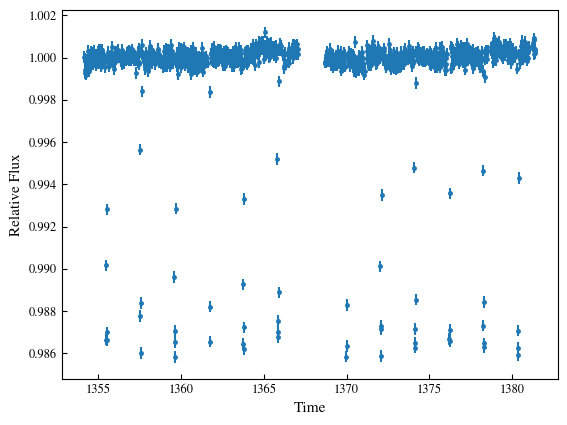

In [12]:
#We can also mask out the parts where there are no transits.
#For this, we first plot out how the light curve data looks like.
plt.errorbar(df["time"].values, df["flux"].values, df["flux_err"].values, fmt=".")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.show()

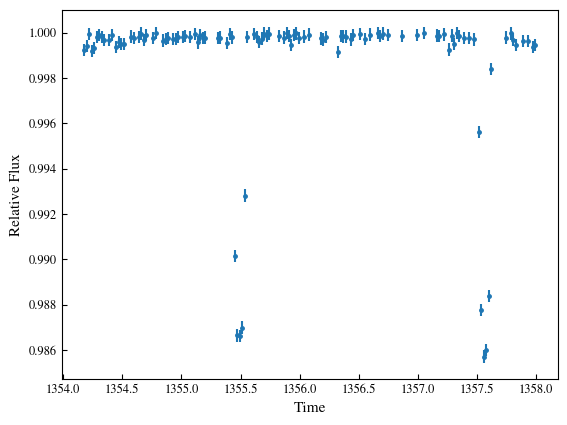

In [13]:
#We then mask out a part of the light curve data (due to memory issues).
mask = (t <= 1358) & (flux <= 1.000)

#We then apply this mask to our dataframe.
t = t[mask]
flux = flux[mask]
flux_err = flux_err[mask]

#We can then plot the masked light curve data.
plt.errorbar(t, flux, flux_err, fmt=".")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)
plt.show()

## Setting up the Priors 

In [16]:
#We then import the Prior file for the Transit-Only Fit.
f = "../../data/lcpriors/WASP97_PriorsLC.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/lc-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Log-Likelihood

In [17]:
#We then pull time, flux and flux errors from the arrays that we have masked.
t = t
flux = flux
e_flux = flux_err

#We then use "LPFunctionTransit" for the Transit-Only Fit.
    #"LPFunction" => Log-Likelihood Function
    #"Transit" => Transit-Only Fit

#We setup our Log-Likelihood Function by using the dataset and the prior file.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionTransitOnly(t, flux, e_flux, file_priors = f)

Reading in priorfile from ../../data/lcpriors/WASP97_PriorsLC.txt
   prior          arg1          arg2     label description priortype  fixed
0     NP  2.072760e+00  2.100000e-07      P_p1        P_p1     model  False
1     UP  6.000000e+00  7.000000e+00      a_p1        a_p1     model  False
2     NP  2.458554e+06  7.400000e-05     t0_p1       t0_p1     model  False
3     FP  0.000000e+00  0.000000e+00    ecc_p1      ecc_p1     model   True
4     FP  9.000000e+01  9.000000e+01  omega_p1    omega_p1     model   True
5     UP  1.000000e-01  6.000000e-01      b_p1        b_p1     model  False
6     UP  1.000000e-01  2.000000e-01      p_p1        p_p1     model  False
7     NP  2.582400e+00  1.920000e-01   tdur_p1     tdur_p1     model  False
8     UP  5.000000e-01  1.000000e+00        u1          u1     model  False
9     UP  5.000000e-01  1.000000e+00        u2          u2     model  False
10    FP  0.000000e+00  0.000000e+00     gamma       gamma     model   True
11    FP  2.083333e-02

In [18]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitTransitOnly(L)

## Setting up the MCMC run

In [19]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolution iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=8000,mc_iter=15000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0      P_p1  2.072760e+00  2.072759e+00  2.072761e+00  2.072760e+00 -3.855482e-07
1      a_p1  6.500000e+00  6.000000e+00  7.000000e+00  6.211878e+00  2.881220e-01
2     t0_p1  2.458554e+06  2.458554e+06  2.458554e+06  2.458554e+06 -1.951121e-07
3      b_p1  3.500000e-01  1.000000e-01  6.000000e-01  5.999115e-01 -2.499115e-01
4      p_p1  1.500000e-01  1.000000e-01  2.000000e-01  1.079480e-01  4.205201e-02
5   tdur_p1  2.582400e+00  1.622400e+00  3.542400e+00  2.191370e+00  3.910302e-01
6        u1  7.500000e-01  5.000000e-01  1.000000e+00  5.001500e-01  2.498500e-01
7        u2  7.500000e-01  5.000000e-01  1.000000e+00  6.964103e-01  5.358968e-02
8  sigma_tr  2.500000e-01  0.000000e+00  5.000000e-01  1.447376e-04  2.498553e-01
LogPost value: 752.20016816859
LnL value: 727.1031962631387
Log priors 25.096971905451422
Running MCMC
MCMC iterations

## Flattening the Chains

In [20]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionTransitOnly
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [21]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

P_p1      a_p1         t0_p1      b_p1      p_p1   tdur_p1  \
0        2.07276  6.426190  2.458554e+06  0.596588  0.107051  2.191799   
1        2.07276  6.426190  2.458554e+06  0.596588  0.107051  2.191799   
2        2.07276  6.426190  2.458554e+06  0.596588  0.107051  2.191799   
3        2.07276  6.395308  2.458554e+06  0.598770  0.106981  2.191906   
4        2.07276  6.395308  2.458554e+06  0.598770  0.106981  2.191906   
...          ...       ...           ...       ...       ...       ...   
1399995  2.07276  6.456368  2.458554e+06  0.425586  0.100148  2.193392   
1399996  2.07276  6.456368  2.458554e+06  0.425586  0.100148  2.193392   
1399997  2.07276  6.456368  2.458554e+06  0.425586  0.100148  2.193392   
1399998  2.07276  6.456368  2.458554e+06  0.425586  0.100148  2.193392   
1399999  2.07276  6.387267  2.458554e+06  0.457241  0.101363  2.192958   

               u1        u2  sigma_tr  
0        0.644086  0.570634  0.000179  
1        0.644086  0.570634  0.000179  
2        0.644086  0.570634  0.000179  
3        0.644282  0.575526  0.000180  
4        0.644282  0.575526  0.000180  
...           ...       ...       ...  
1399995  0.724387  0.606215  0.000163  
1399996  0.724387  0.606215  0.000163  
1399997  0.724387  0.606215  0.000163  
1399998  0.724387  0.606215  0.000163  
1399999  0.678760  0.634887  0.000162  

[1400000 rows x 9 columns]

## Assessing the Chains

In [22]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

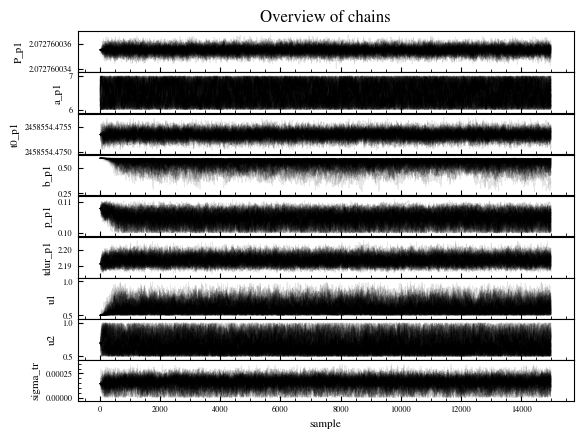

In [23]:
#We use the plot_chains function from the mcmc_help module to plot the chains.
#Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

plt.show();

In [24]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.00672923 1.00762798 1.00597809 1.01051108 1.00953867 1.00791678
 1.00848162 1.00850155 1.00582228]
--------------------------------------------------


In [25]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40

try:
    print(50 * "-")
    print("Autocorrelation Time")
    print(50 * "-")
    tau = TF.sampler.get_autocorr_time()
    print(tau)

    #We can also divide the length of the chain by the autocorrelation time to get the number of s
    #independent samples.
    print(50 * "-")
    print("Number of Independent Samples")
    print(50 * "-")
    N_eff = len(flatchain) / tau
    print(N_eff)
    print(50 * "-")
    
except Exception as e:
    print("Error calculating the autocorrelation time:", e)
print(50 * "-")


--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
[178.44604788 192.29306986 160.10301161 268.01524701 242.77542641
 193.3704722  203.99154409 196.06173482 169.68754538]
--------------------------------------------------
Number of Independent Samples
--------------------------------------------------
[7845.50858141 7280.55358948 8744.37017696 5223.58341789 5766.64624042
 7239.98852597 6863.02957429 7140.60804013 8250.45819884]
--------------------------------------------------
--------------------------------------------------


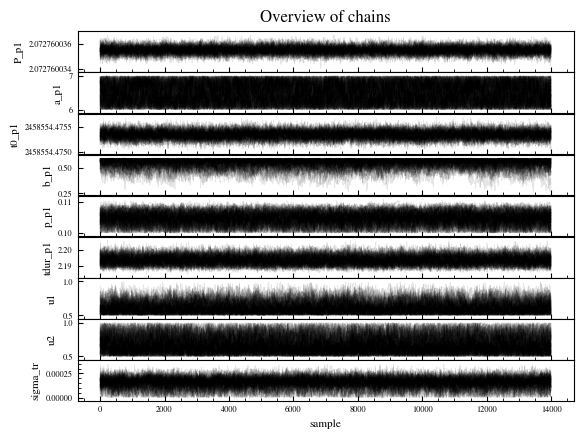

In [26]:
#We can also check how the flatchains look by plotting the flatchains.
mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
plt.show();

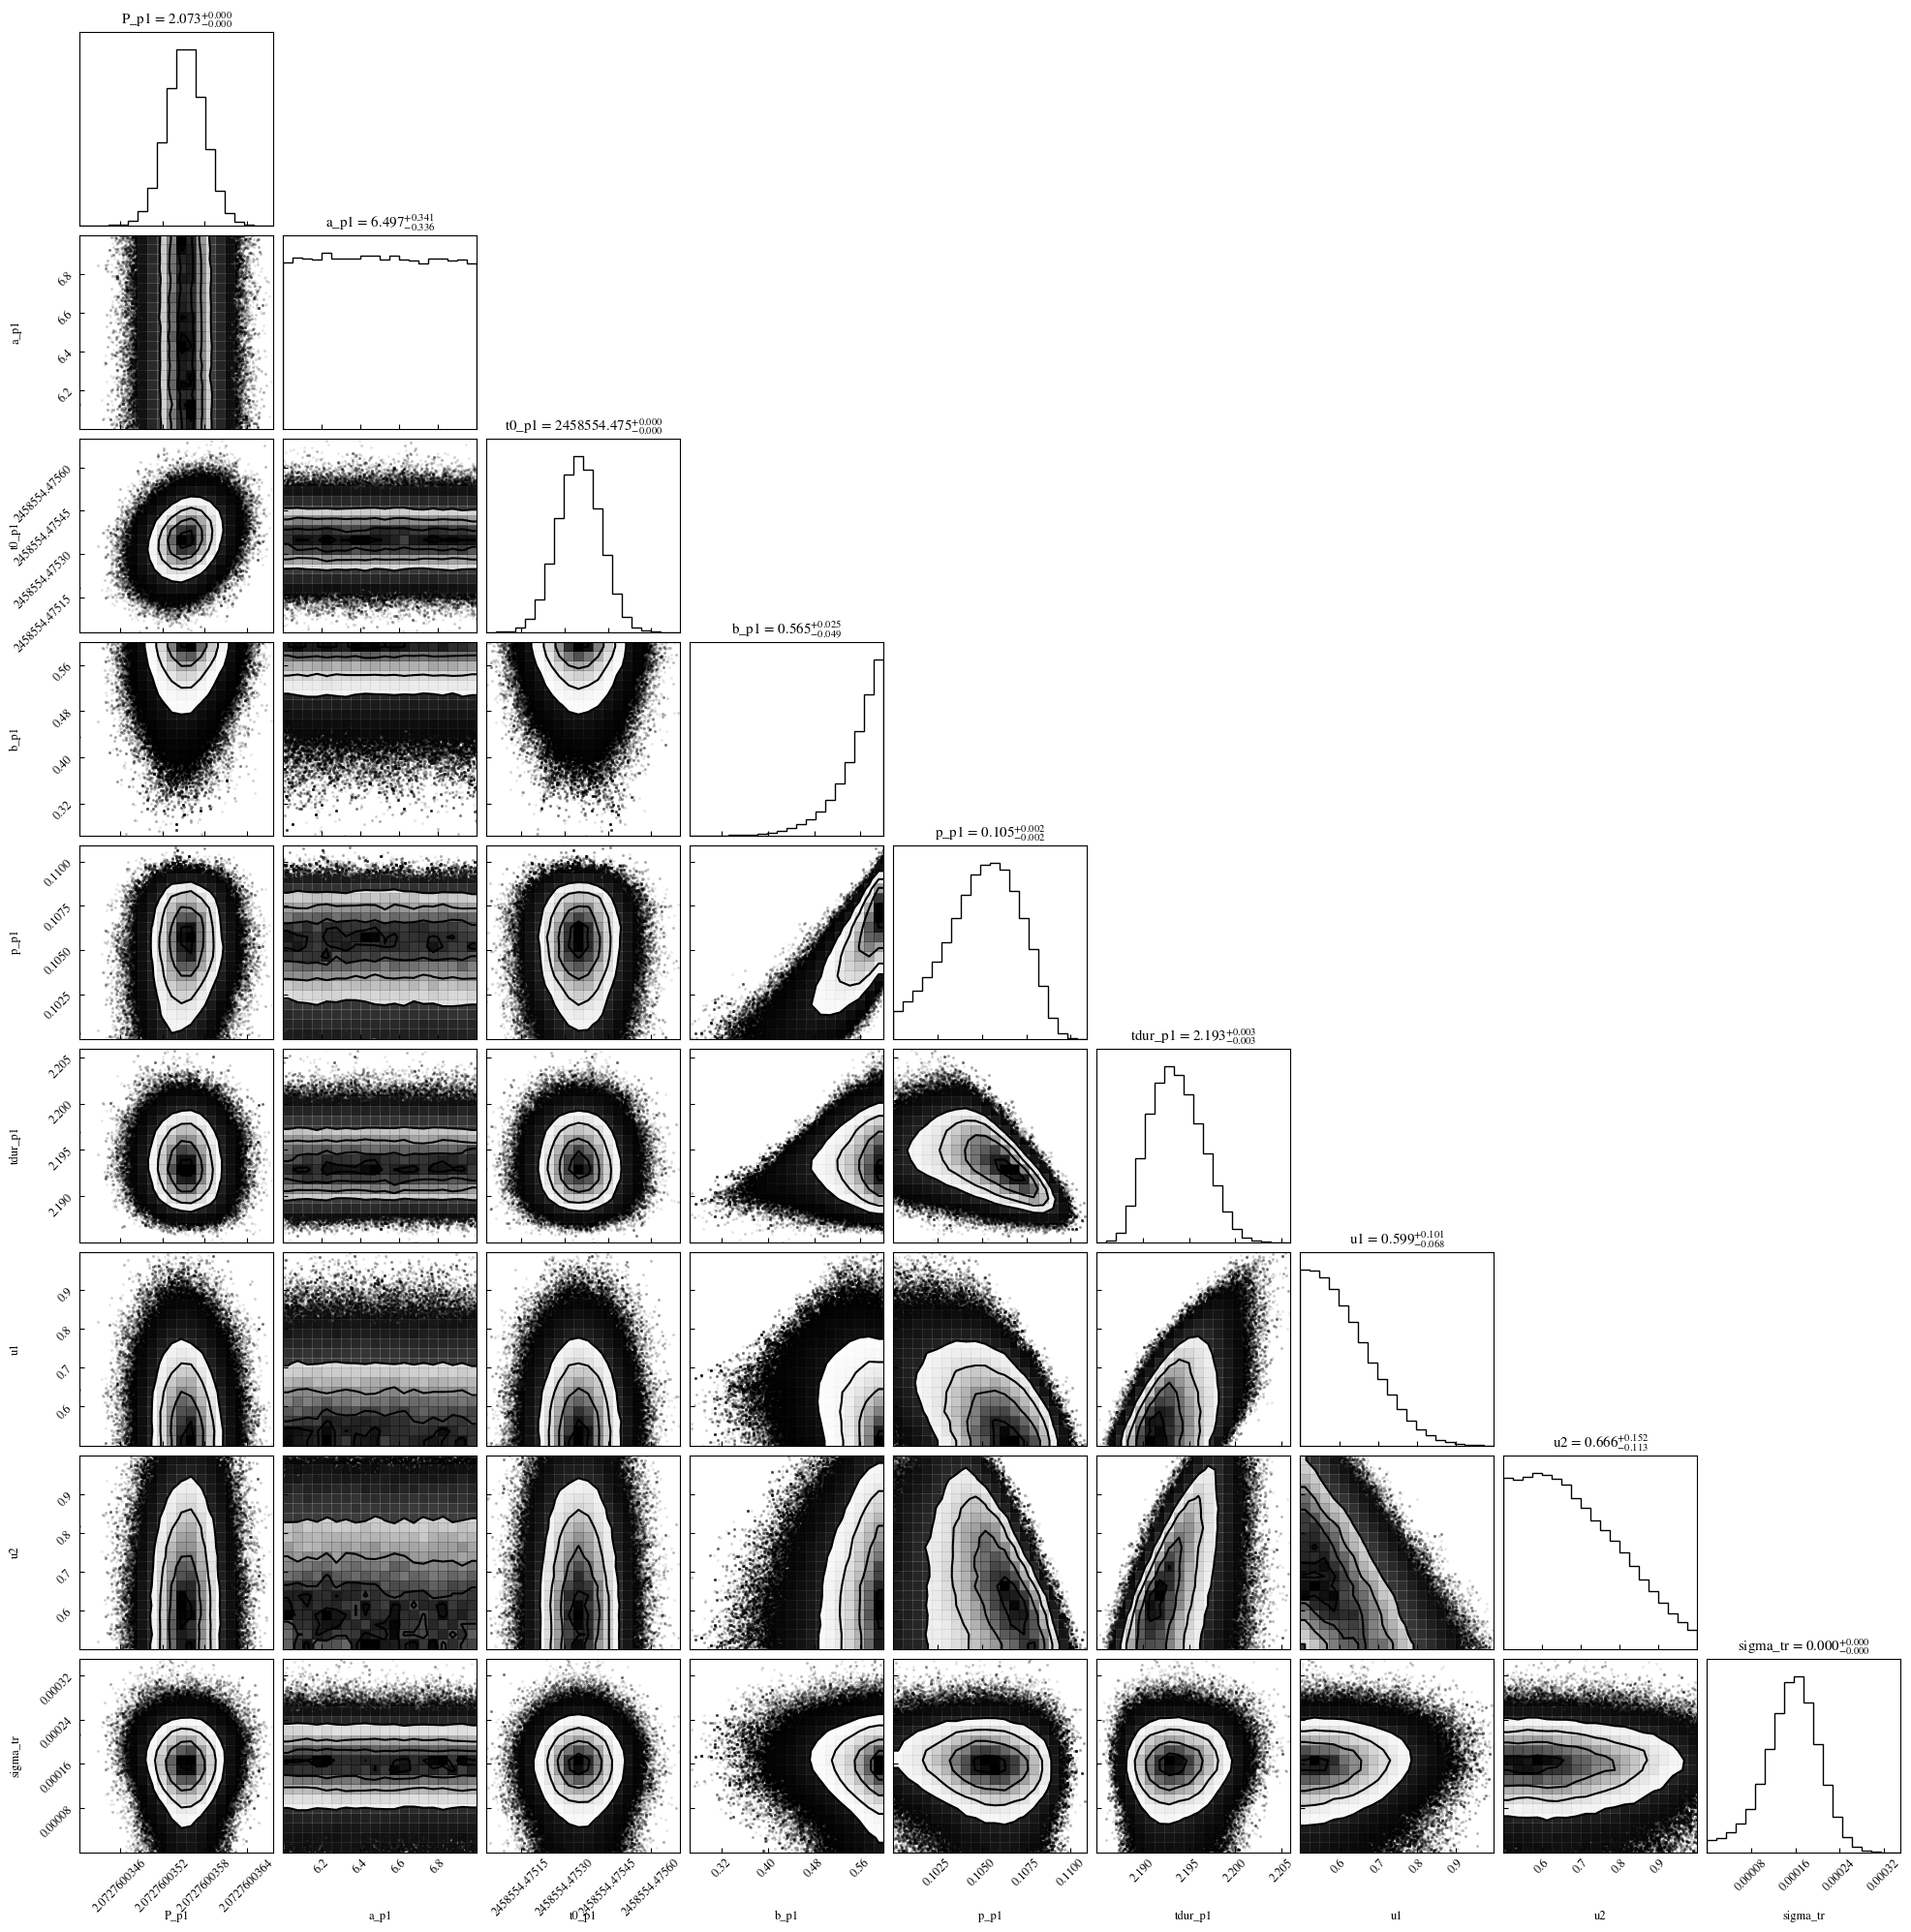

In [27]:
#We can also plot the corner plot to see the correlations and the posterior distributions
#of each parameter that was in the MCMC run.
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

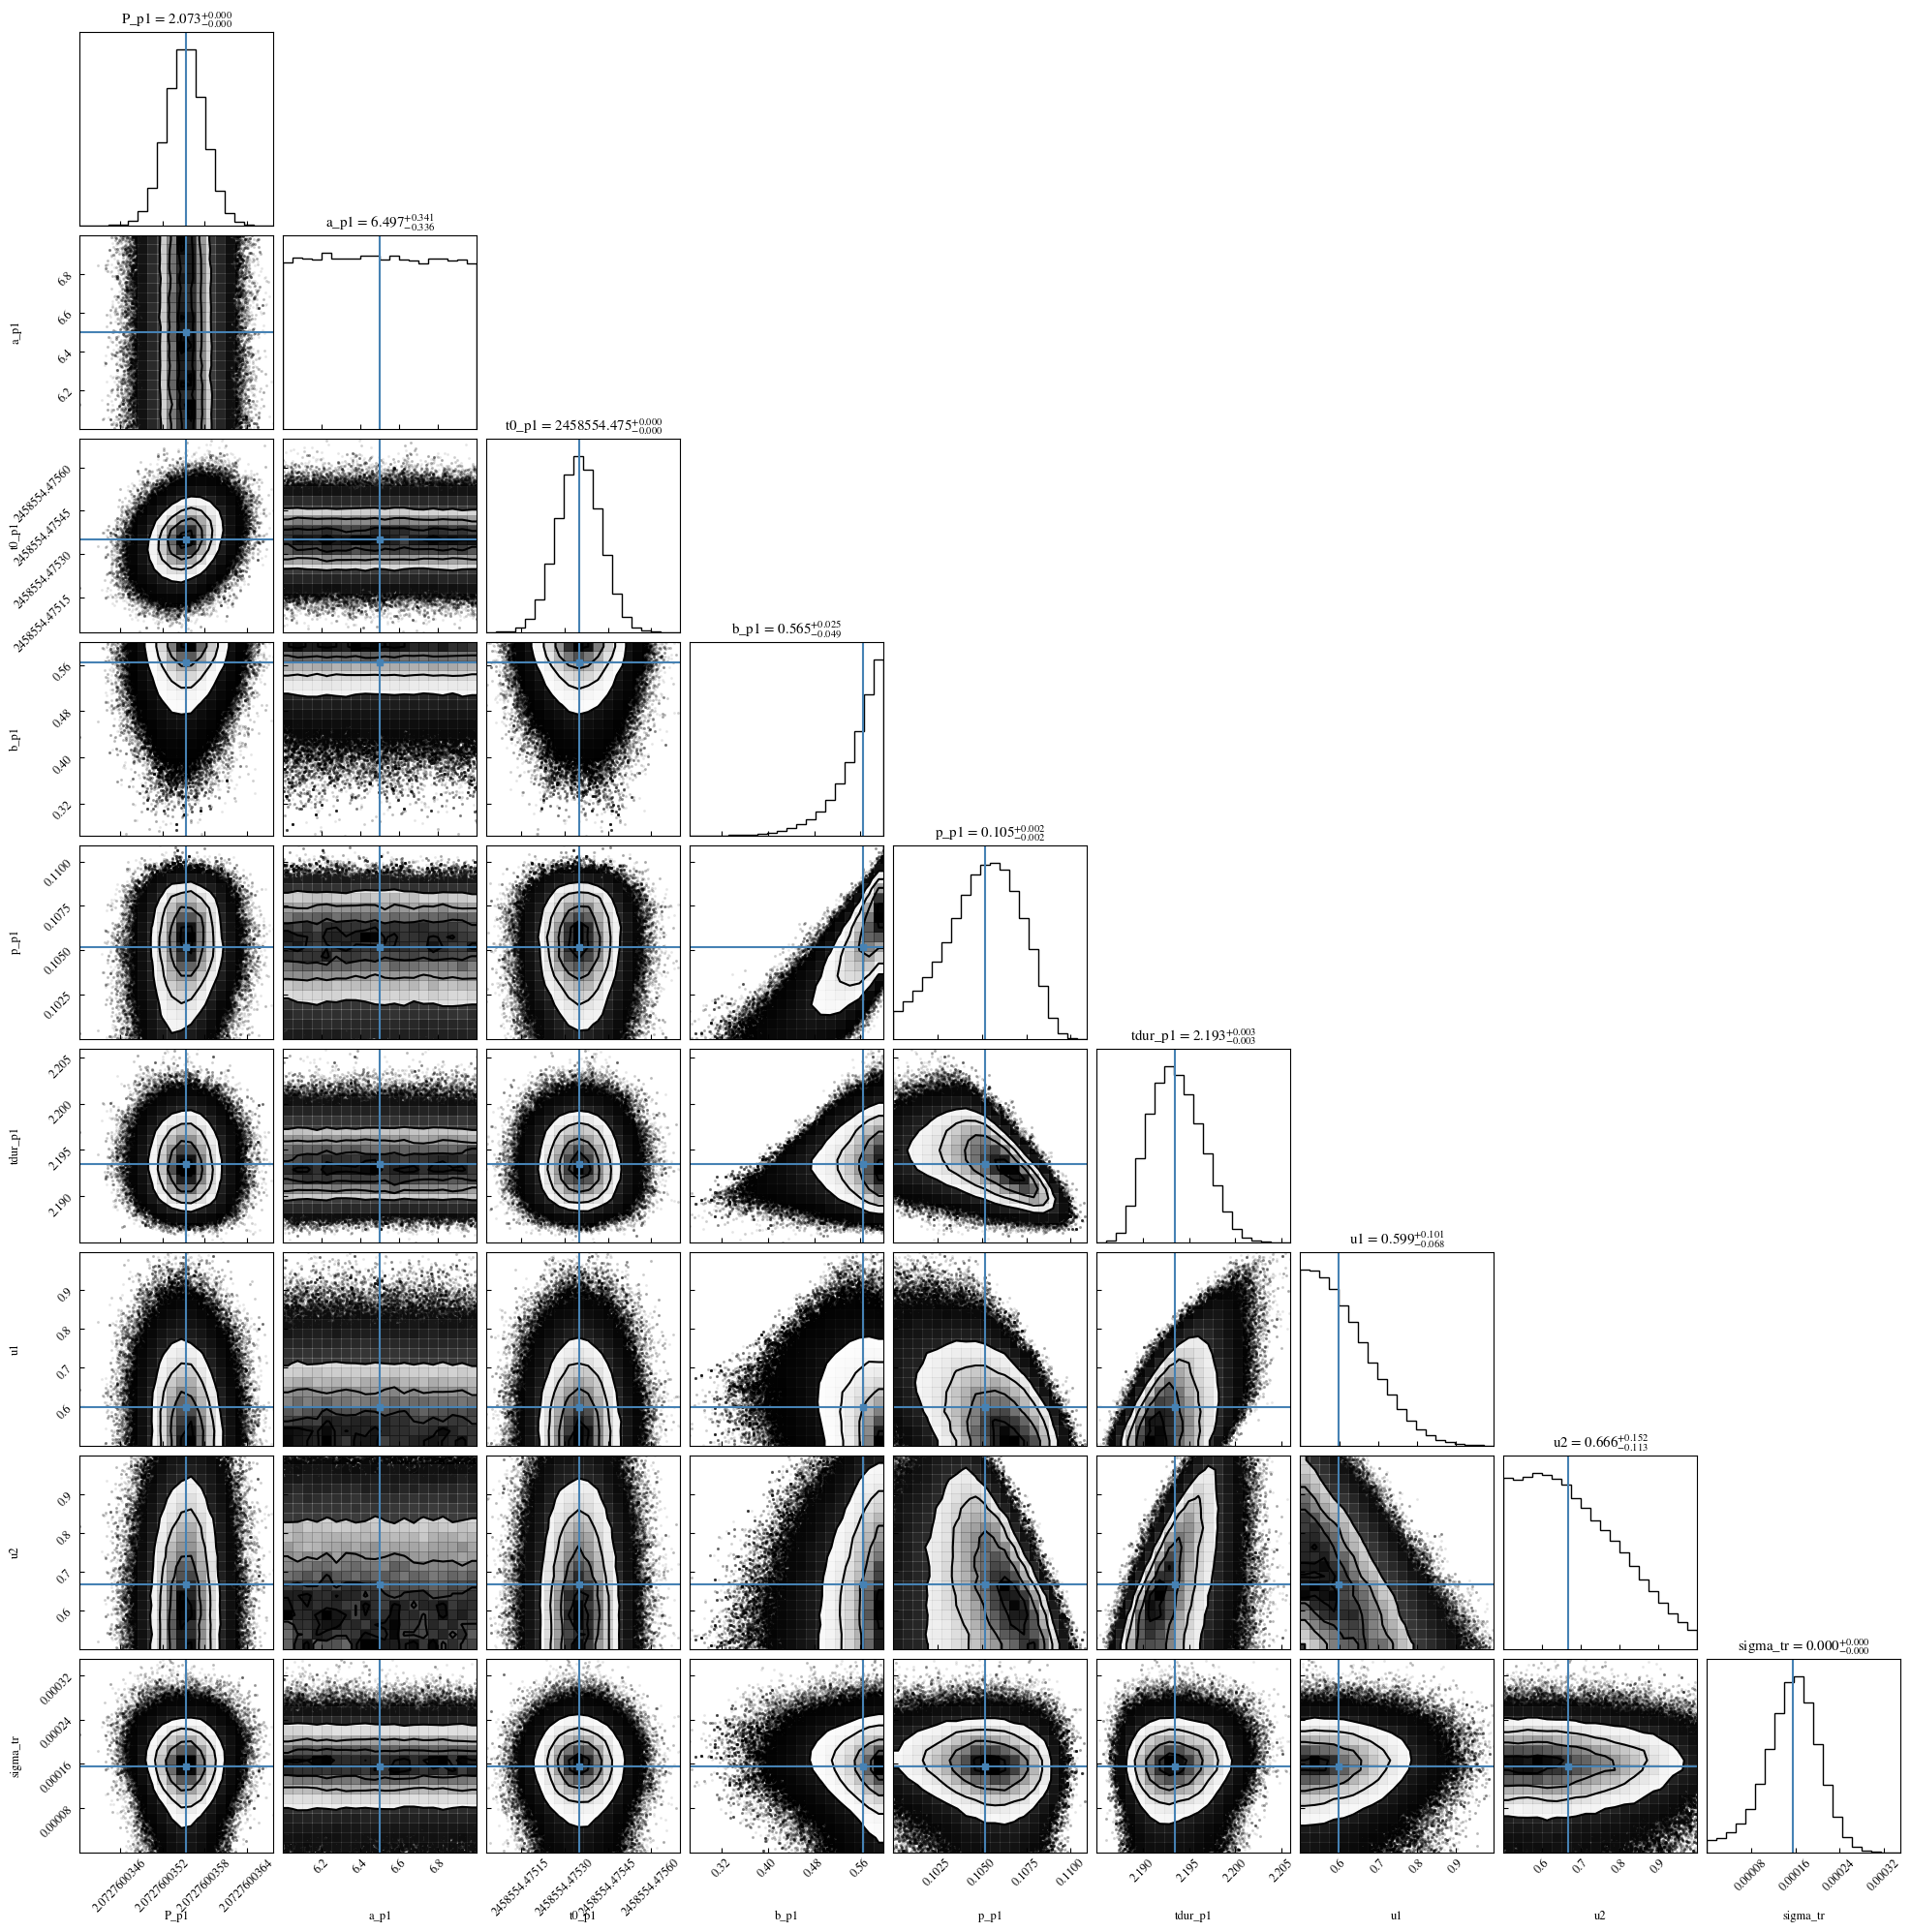

In [28]:
#We can also plot the corner plot with 50th percentile, i.e., the median to see whether
#the posterior distributions are sampled correctly or not.
#We first find the median of each parameter.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We then plot the corner plot and the median.
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

## Working with the Posteriors

In [29]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionTransitOnly.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

medvals         minus          plus  \
0  2.072760e+00  2.650071e-10  2.638982e-10   
0  6.496925e+00  3.363396e-01  3.411965e-01   
0  2.458554e+06  7.426087e-05  7.383479e-05   
0  5.652248e-01  4.927342e-02  2.521453e-02   
0  1.051985e-01  2.307046e-03  1.953316e-03   
0  2.193493e+00  2.673446e-03  3.041358e-03   
0  5.986504e-01  6.832979e-02  1.008126e-01   
0  6.660572e-01  1.125086e-01  1.515675e-01   
0  1.554913e-04  5.072605e-05  4.418542e-05   

                                            values    Labels Description  
0  $2.07276003553_{-0.0000000003}^{+0.0000000003}$      P_p1        P_p1  
0                            $6.5_{-0.34}^{+0.34}$      a_p1        a_p1  
0           $2458554.475351_{-0.00007}^{+0.00007}$     t0_p1       t0_p1  
0                        $0.565_{-0.049}^{+0.025}$      b_p1        b_p1  
0                     $0.1052_{-0.0023}^{+0.0020}$      p_p1        p_p1  
0                     $2.1935_{-0.0027}^{+0.0030}$   tdur_p1     tdur_p1  
0                         $0.599_{-0.068}^{+0.10}$        u1          u1  
0                           $0.67_{-0.11}^{+0.15}$        u2          u2  
0                 $0.000155_{-0.00005}^{+0.00004}$  sigma_tr    sigma_tr

In [30]:
df_medvals[["Labels", "values"]]

Labels                                           values
0      P_p1  $2.07276003553_{-0.0000000003}^{+0.0000000003}$
0      a_p1                            $6.5_{-0.34}^{+0.34}$
0     t0_p1           $2458554.475351_{-0.00007}^{+0.00007}$
0      b_p1                        $0.565_{-0.049}^{+0.025}$
0      p_p1                     $0.1052_{-0.0023}^{+0.0020}$
0   tdur_p1                     $2.1935_{-0.0027}^{+0.0030}$
0        u1                         $0.599_{-0.068}^{+0.10}$
0        u2                           $0.67_{-0.11}^{+0.15}$
0  sigma_tr                 $0.000155_{-0.00005}^{+0.00004}$

## Plotting the Data and the Best-Fit Model

In [33]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "WASP-97 Transit-Only Fit"
NUM_SAMPLES = 5000

### Plotting the Data and the Best-Fit Model over Time

In [34]:
#We can first plot the data and the best-fit model over time.
    #Optional: If there we want to convert Julian Dates into Datetimes, i.e. DD-MM-YYYY format,
    #we can use ExoMUSE_utils.jd2datetime(times) function, where times is in Julian Dates.

#For this, we first get the times from our dataset.
times_data = TF.lpf.data["x"]

times_data

array([1354.18059784, 1354.20143148, 1354.22226513, 1354.24309877,
       1354.26393241, 1354.28476605, 1354.3055997 , 1354.32643334,
       1354.34726698, 1354.38893426, 1354.4097679 , 1354.45143518,
       1354.47226882, 1354.49310246, 1354.51393609, 1354.57643701,
       1354.59727064, 1354.63893791, 1354.65977155, 1354.68060518,
       1354.70143882, 1354.76393972, 1354.78477335, 1354.84727424,
       1354.86810787, 1354.8889415 , 1354.93060876, 1354.95144239,
       1354.97227602, 1355.01394328, 1355.0347769 , 1355.07644416,
       1355.11811141, 1355.13894503, 1355.15977866, 1355.18061228,
       1355.2014459 , 1355.30561402, 1355.32644764, 1355.3889485 ,
       1355.40978212, 1355.43061573, 1355.45144935, 1355.47228297,
       1355.49311659, 1355.5139502 , 1355.53478382, 1355.55561744,
       1355.61811828, 1355.6389519 , 1355.65978551, 1355.68061912,
       1355.70145274, 1355.72228635, 1355.74311996, 1355.82645441,
       1355.86812163, 1355.88895524, 1355.90978884, 1355.93062

In [35]:
#We first get the medians of the parameters by using the flatchain.
#This again can be obtained by checking the 50th percentile of the flatchains.
pv_50 = np.percentile(flatchain, [50], axis=0)[0]

#We then define the amount of times where we will sample the Best-Fit Model.
times_model = np.linspace(times_data.min(), times_data.max(), NUM_SAMPLES)

#We then compute the best-fit model by using the median values and defined times.
tr_model = TF.lpf.compute_total_model(pv_50, times_model)

#We also compute the radial velocity data from the model at the observation times.
tr_data_from_model = TF.lpf.compute_total_model(pv_50, times_data)

#From here, we can calculate the residuals, i.e., DATA - MODEL
residuals = TF.lpf.data["y"] - tr_data_from_model

In [36]:
#We can also plot the uncertainty intervals of our model.
#For this, we can define the following loop that does:
    #1-) Sample a random vector of parameters from the flatchain. E.g. 200th chain
    #2-) Compute the Transit curve using the sampled parameter set/vector.
    #3-) Add this Transit curve model to a list.
    #4-) Sample from this list to get the uncertainty intervals.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    tr_models_for_uncertainty.append(model)

#We then convert this list to an array.
tr_models_for_uncertainty = np.array(tr_models_for_uncertainty)

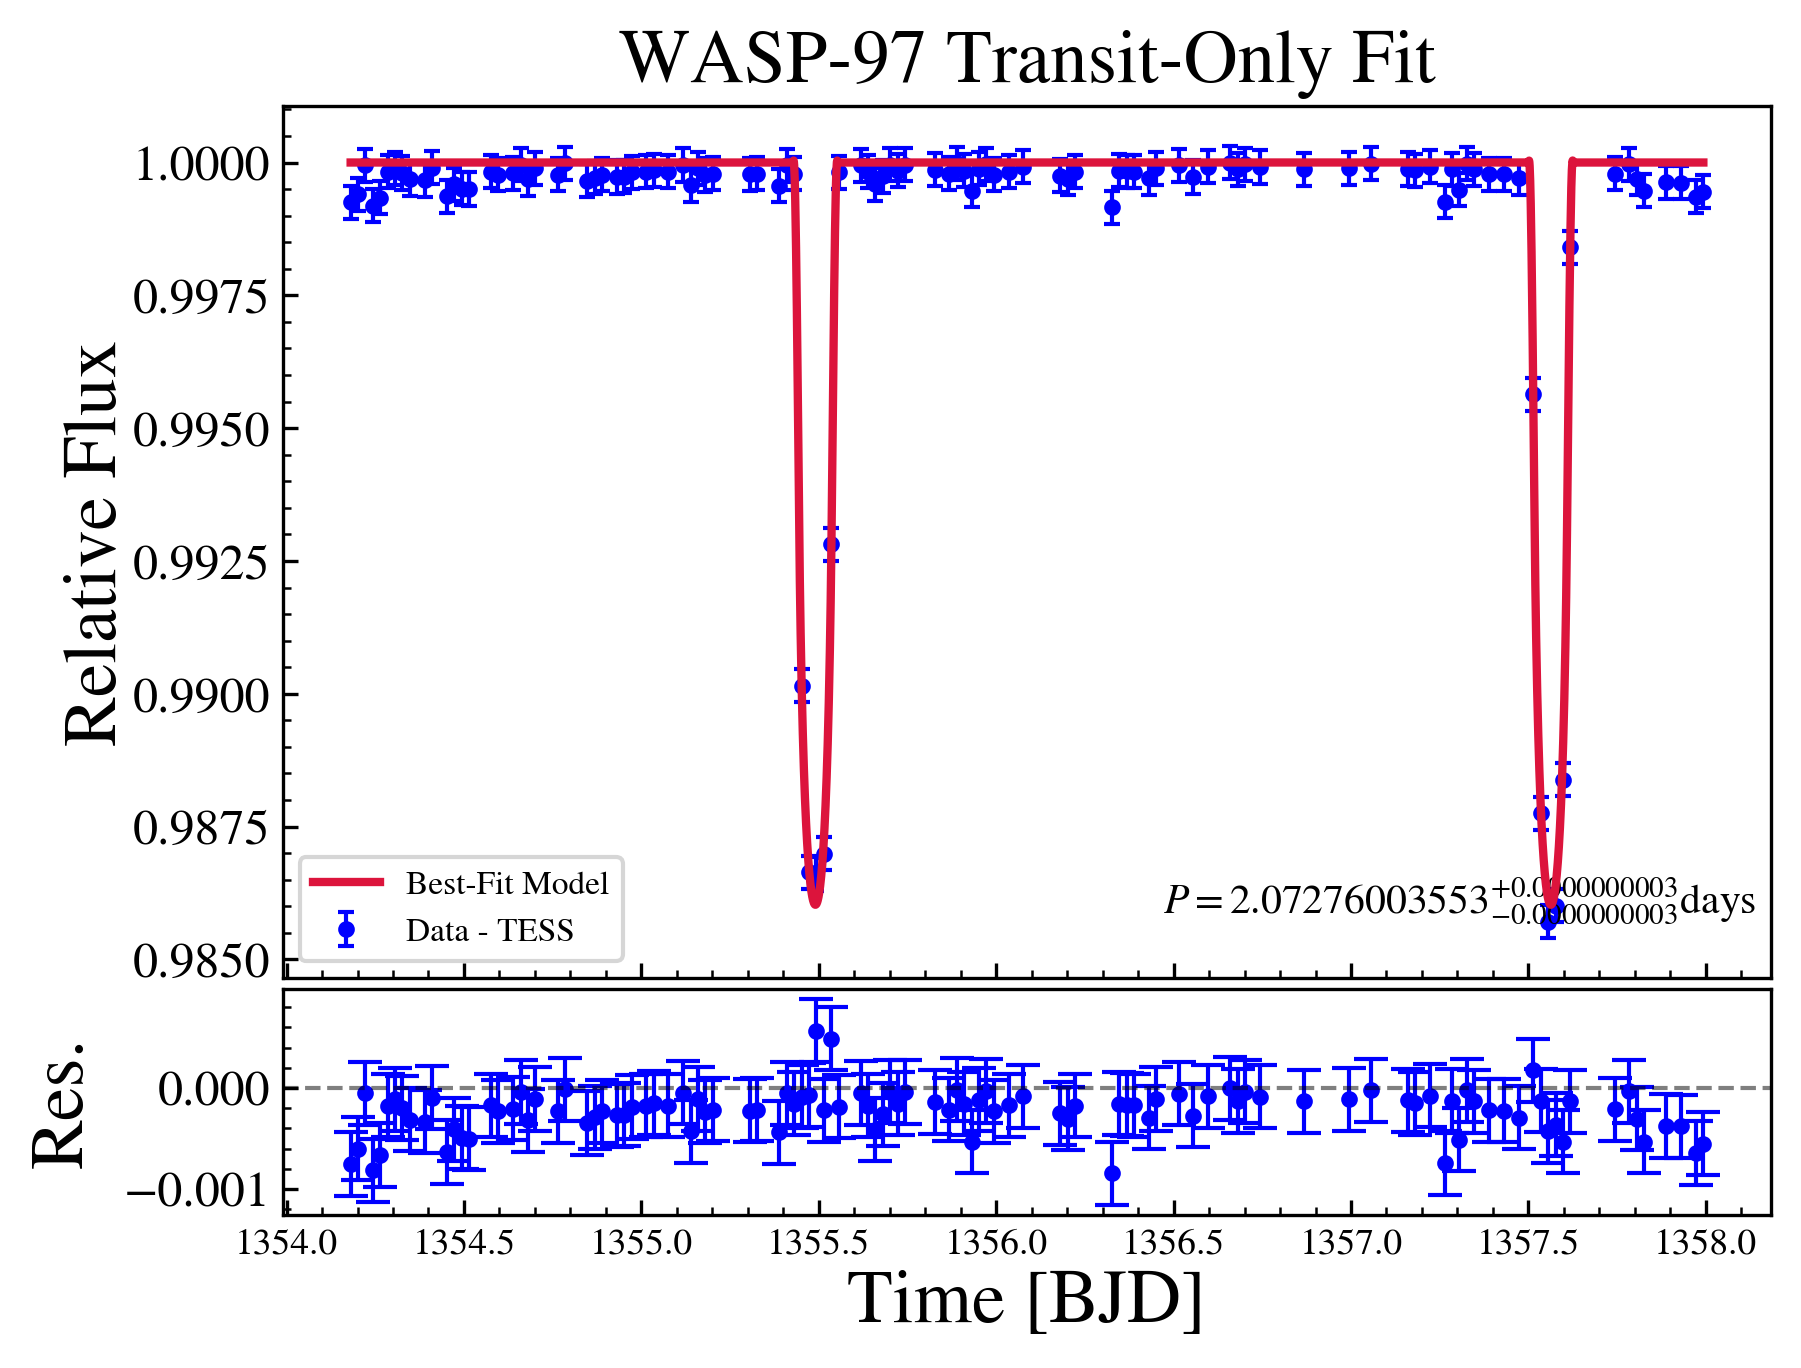

In [37]:
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of RV uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(TF.lpf.data["x"], TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - TESS', zorder = -100)

#We also plot our best-fit model.
ax.plot(times_model, tr_model, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(TF.lpf.data["x"], residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -100)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty.
#1 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(times_model, 
#                 np.percentile(tr_models_for_uncertainty, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Time [BJD]',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

### Plotting the Data and the Best-Fit Model over Phase

In [38]:
#To plot the Data and the Best-Fit model over Phase, we first need to get the Period and T0
#from the flatchains.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "t0_p1"].values[0]

#We can then use ExoMUSE_utils.time_to_phase(times, P, T0) function to convert the times
#to phase.
phase_data = ExoMUSE_utils.time_to_phase(times_data, P, T_0, phase_method="centered")

#We then convert the model times to phase too.
phase_model = ExoMUSE_utils.time_to_phase(times_model, P, T_0, phase_method="centered")

#We then have to sort the data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
tr_model_sorted = tr_model[sorted_indices]

In [39]:
#We can again the uncertainty intervals of our model.
#It is the same structure as before.

#For this we first define a list to store all of the Transit models.
tr_models_for_uncertainty_phase = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model = TF.lpf.compute_total_model(flatchain[idx], times = times_model)
    model_sorted = model[sorted_indices]
    tr_models_for_uncertainty_phase.append(model_sorted)

#We then convert this list to an array.
tr_models_for_uncertainty_phase = np.array(tr_models_for_uncertainty_phase)

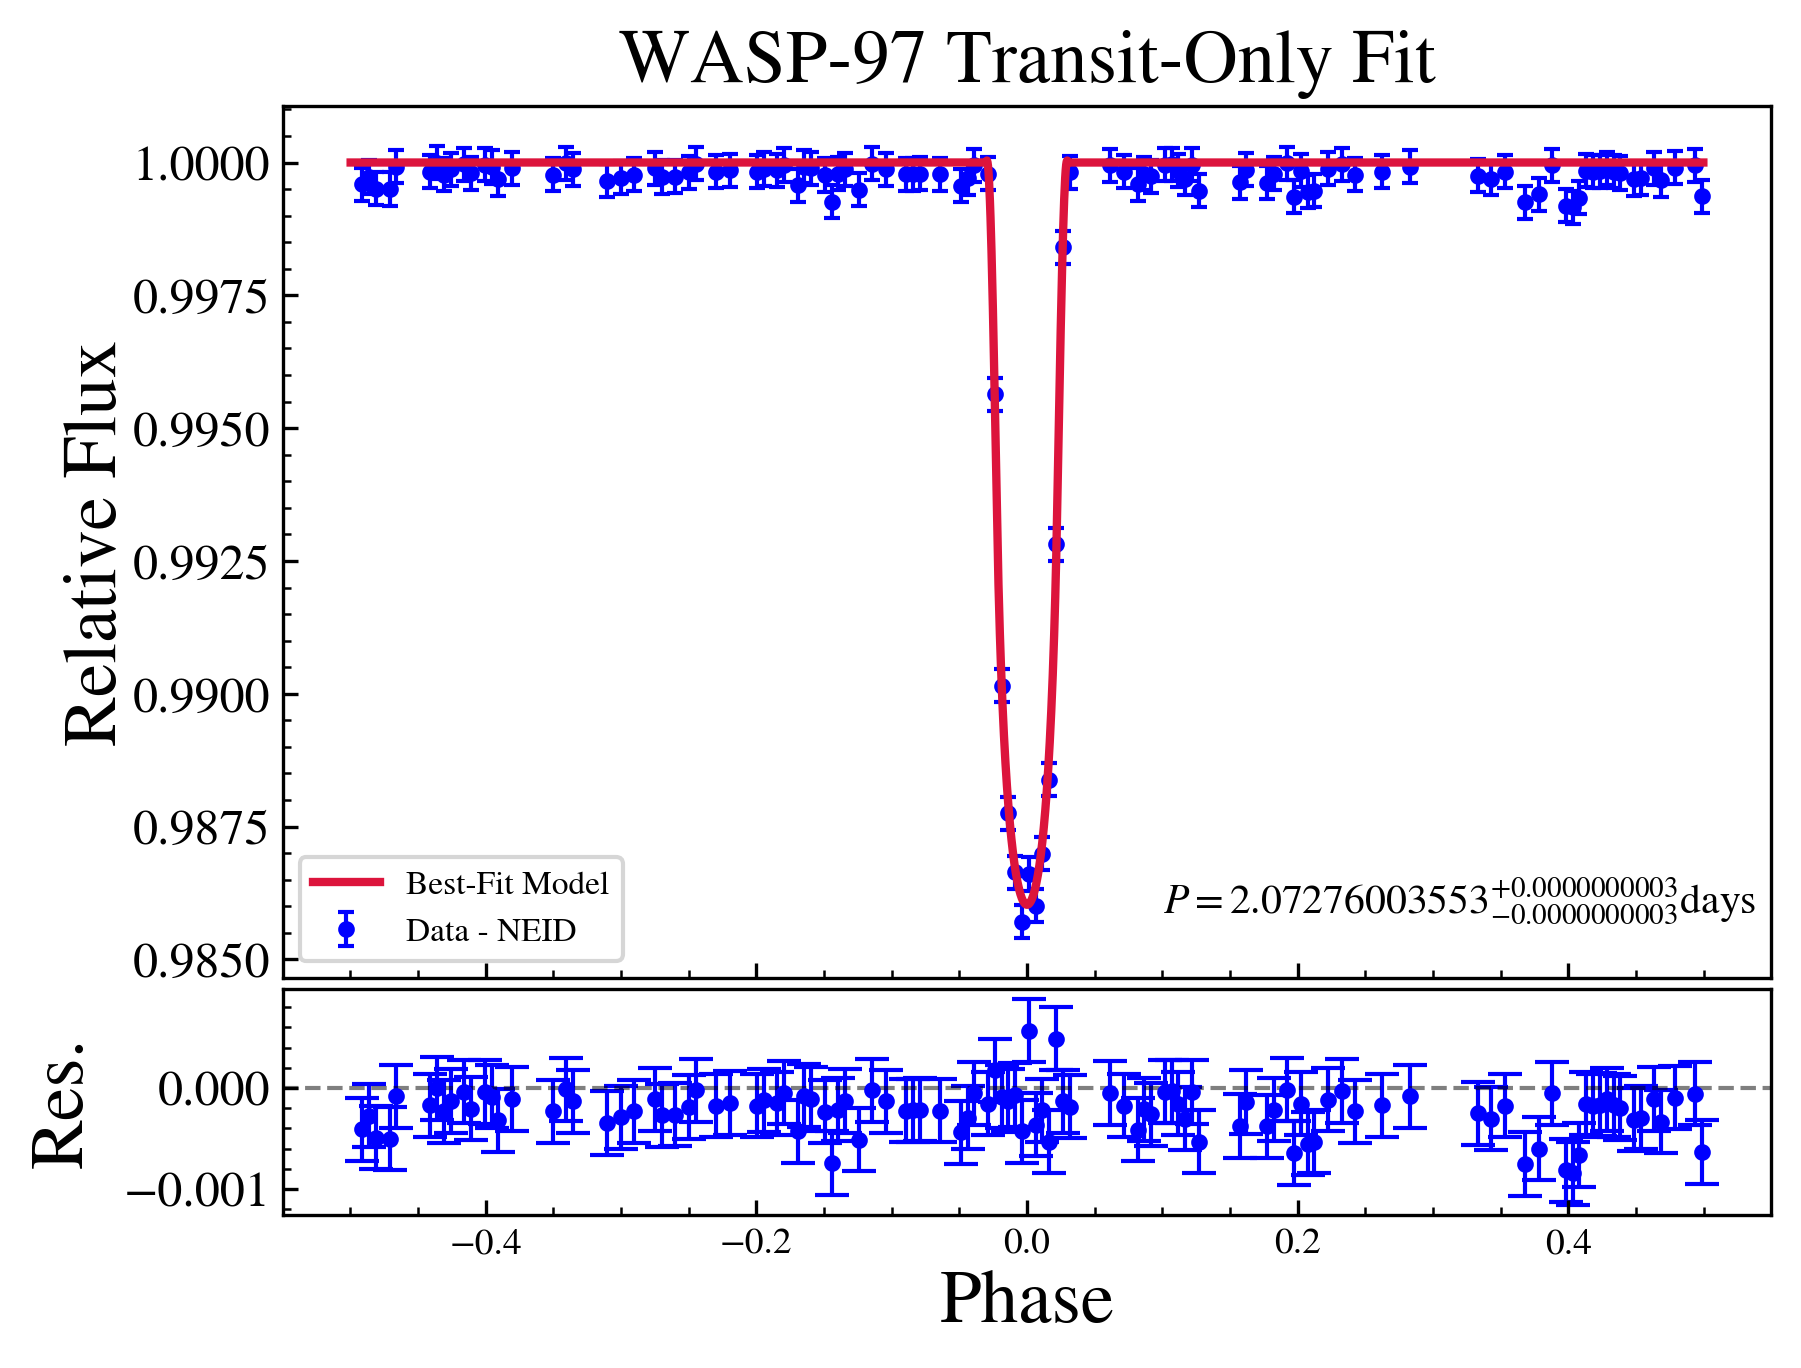

In [40]:
#We can then again plot the data as follows.
#We then plot our data.
#For this we define 2 rows with one of them for the Flux and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"

#We can also add the model of Flux uncertainties into the datapoints.
    #uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]

#In this fit, it was varied.
uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_tr"].values[0]
inflated_tr_err = np.sqrt(pow(TF.lpf.data["error"], 2) + pow(uncertainty_sigma, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(phase_data, TF.lpf.data["y"], yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - NEID', zorder = -10)

#We also plot our best-fit model.
ax.plot(phase_model_sorted, tr_model_sorted, color="crimson", label = "Best-Fit Model", lw=2., zorder=10)

#We then plot the residuals.
bx.errorbar(phase_data, residuals, yerr = inflated_tr_err,
            marker='.', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the Transit graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using tr_models_for_uncertainty_phase.
#1 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 16, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 84, axis=0),
#                 color='#EE2C2C', alpha=0.3)
# #2 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 2, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 98, axis=0),
#                 color='#EE2C2C', alpha=0.2)
# #3 Sigma Interval
# ax.fill_between(phase_model_sorted, 
#                 np.percentile(tr_models_for_uncertainty_phase, 0.15, axis=0),
#                 np.percentile(tr_models_for_uncertainty_phase, 99.85, axis=0),
#                 color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('Relative Flux',labelpad=0,fontsize=18)
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res.',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]+0, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

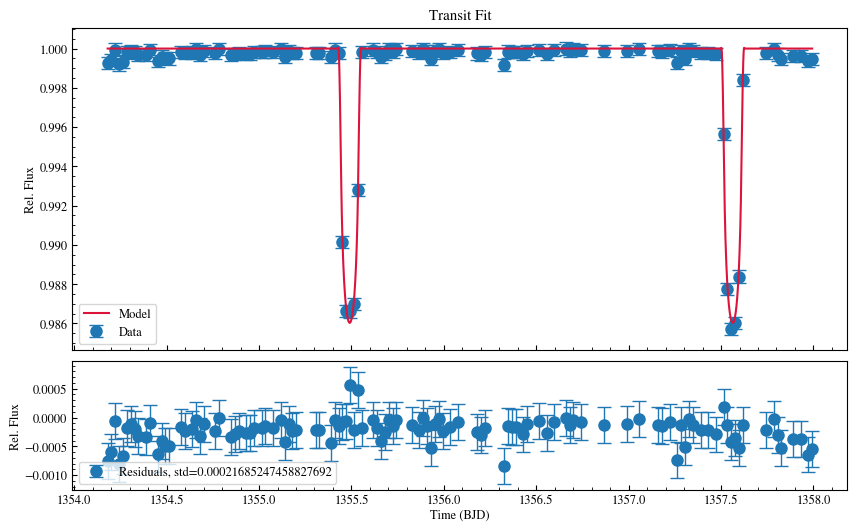

In [41]:
#If needed, it is also possible to quickly plot the best-fit model with a simple function inside ExoMUSE_fit.
    #pv: Parameter Values, add medial values.
    #times: Times that we want to evaluate the model on.
quick_plot = TF.plot_fit(pv = df_medvals["medvals"].values, times=times_model)
plt.show()